## Data Distribution

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from CNN.loader import get_split
from CNN.model import train
    
DATA_DIR = os.path.join('data', 'mammals_calls')
h = 164
w = 397

np.random.seed(2025)

2025-08-28 12:38:49.955222: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 12:38:49.968518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756377529.985827    5801 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756377529.990981    5801 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756377530.003931    5801 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

No GPU found, using CPU
No GPU found, using CPU


2025-08-28 12:38:53.240102: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
subfolders = [f.path for f in os.scandir(DATA_DIR) if f.is_dir()]
data_info = {}
for subfolder in subfolders:
    species_name = os.path.basename(subfolder)
    file_count = len([f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))])
    data_info[species_name] = file_count
count_df = pd.DataFrame(list(data_info.items()), columns=['species', 'file_count'])
count_df = count_df.sort_values(by='file_count', ascending=False)


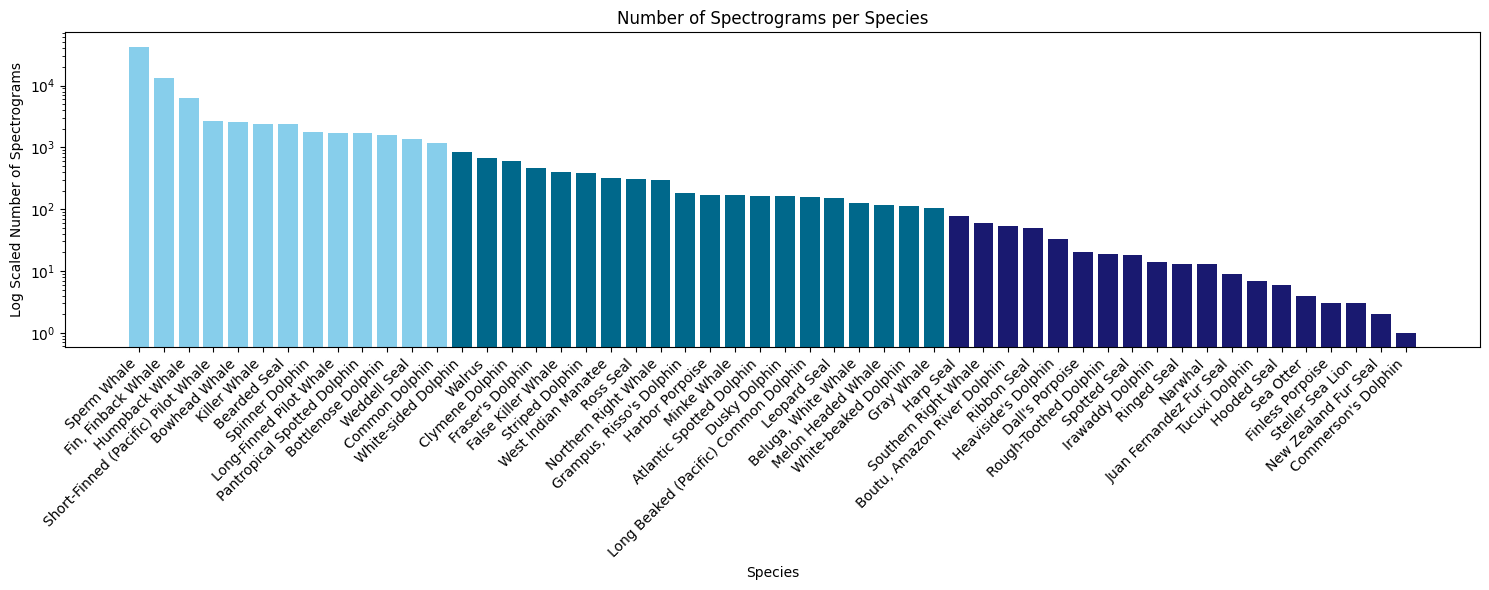

Total number of species: 52
Number of species with more than 1000 spectrograms: 13
Number of species with more than 100 but less than 1000 spectrograms: 20
Number of species with less than 100 spectrograms: 19


In [3]:
count_thousands = count_df[count_df['file_count'] > 1000]
count_hundreds = count_df[(count_df['file_count'] > 100) & (count_df['file_count'] < 1000)]
count_tens = count_df[count_df['file_count'] < 100]

plt.figure(figsize=(15, 6))
plt.bar(count_thousands['species'], count_thousands['file_count'], color="#87CEEB")
plt.bar(count_hundreds['species'], count_hundreds['file_count'], color='#00688B')
plt.bar(count_tens['species'], count_tens['file_count'], color="#191970")
plt.xlabel('Species')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Log Scaled Number of Spectrograms')
plt.yscale("log")
plt.title('Number of Spectrograms per Species')

plt.tight_layout()
plt.show()

print(f'Total number of species: {count_df.shape[0]}')
print(f'Number of species with more than 1000 spectrograms: {count_thousands.shape[0]}')
print(f'Number of species with more than 100 but less than 1000 spectrograms: {count_hundreds.shape[0]}')
print(f'Number of species with less than 100 spectrograms: {count_tens.shape[0]}')


## Training CNN

In [4]:
dataset = os.listdir(DATA_DIR)
class_list = [f for f in dataset if len(os.listdir(os.path.join(DATA_DIR, f))) > 999 and
              os.path.isdir(os.path.join(DATA_DIR, f))]
n_classes = len(class_list)
print(f'Total classes found: {n_classes}')

split_perc = {'train': 0.6, 'val': 0.4}
split_ds = get_split(DATA_DIR, class_list, split_perc, h, w)

Total classes found: 13
Listing all image files path...
Creating and caching data split...
Processing train set with 48846 images...
lunghezza files_path: 48846
numero classi: 13
train set processed and added to the dictionary.
Processing val set with 32564 images...
lunghezza files_path: 32564
numero classi: 13
val set processed and added to the dictionary.


In [5]:
train(split_ds['train'], split_ds['val'], patience=5,cp_path='checkpoints', checkpoint_freq=5, w_h = (w, h), n_classes=n_classes)

training
Epoch 1/50
  19/1527 ━━━━━━━━━━━━━━━━━━━━ 29:59 1s/step - accuracy: 0.5400 - loss: 1.8428

KeyboardInterrupt: 